# 勾配降下法による単回帰モデルの学習を自動微分ライブラリ（PyTorch）を用いて実装した例

## モジュールのインストール
Google Colabに標準でインストールされていないモジュールを最初にインストールしておく

In [1]:
!pip install torchviz
!pip install japanize-matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=f67fe686faa5d92774cc73e1e9060c2bc9ab10a5bd96babedd94dbbe71dcf22d
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=c71eeeef31370667422510dc2426ea2dc1005511250a7ab7ad699067a82b4b18
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 必要なモジュールの読み込み

可視化用のモジュール (Matplotlib) と自動微分の計算用モジュール (PyTorch)

In [2]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import japanize_matplotlib

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F


print('PyTorch version: ' + torch.__version__)

PyTorch version: 2.1.0+cu121


## データの準備とプロット

第10回講義で使用した錠剤製造後の経過時間と含まれる薬物量の関係のデータ ($N = 5$) を用いる．

Text(0, 0.5, '錠剤に含まれる薬物量 [mg]')

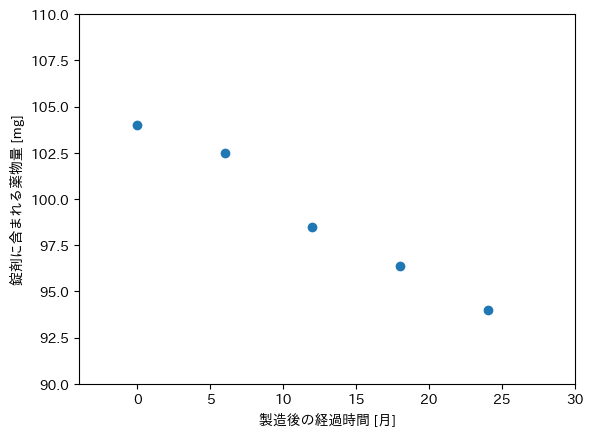

In [3]:
X = torch.tensor([0, 6, 12, 18, 24])
t = torch.tensor([104, 102.5, 98.5, 96.4, 94])

plt.scatter(X, t)
plt.xlim([-4, 30])
plt.ylim([90, 110])
plt.xlabel('製造後の経過時間 [月]')
plt.ylabel('錠剤に含まれる薬物量 [mg]')

## モデルとデータ間の損失関数 (2乗誤差) の計算グラフを描画

* データ： $\{(x_n, t_n)\}_{n=1}^N$
* モデル: $y = a + bx$
* 損失関数：
$$
\begin{align*}
L(a, b) &= \sum_{n=1}^N (t_n - y(x_n))^2 \\
&= \sum_{n=1}^N \left\{t_n - (a + bx_n)\right\}^2 \\
\end{align*}
$$

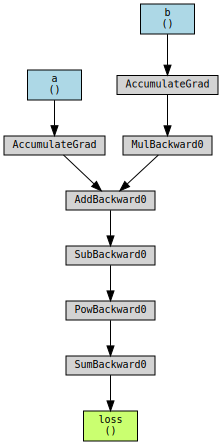

In [4]:
from torchviz import make_dot

# パラメタの初期値を設定（requires_gradは勾配を計算する必要がある変数，つまりパラメタであることを意味する）
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

y_pred = a + b * X
loss = torch.sum((y_pred - t) ** 2)

# 計算グラフの生成
dot = make_dot(loss, params={'a': a, 'b': b, 'loss': loss})
dot.graph_attr.update(size='12,24')

# 計算グラフの図をファイルに保存
dot.render('comp_graph', format='png')
dot.render('comp_graph', format='svg')

dot

In [5]:
loss

tensor(37791.2617, grad_fn=<SumBackward0>)

## 勾配降下法による学習（損失関数を最小にする $a, b$ を探す）


In [6]:
# 学習率
lr = 1e-4

# パラメタの初期値を設定（requires_gradは勾配を計算する必要がある変数，つまりパラメタであることを意味する）
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

# 勾配降下法の実行
for k in tqdm(range(50000)):
    # 各入力データに対するモデル予測の計算
    y_pred = a + b * X
    # 損失関数の計算（モデルによる予測とデータの2乗誤差を計算する）
    loss = torch.sum((y_pred - t) ** 2)

    # 計算グラフを loss ノードから a, b, ノードに向かって逆に辿ることで微分値を計算
    a.grad = torch.tensor(0.0)
    b.grad = torch.tensor(0.0)
    loss.backward()

    # 自動微分によって計算した微分値でパラメタの値を更新する
    # (ここでは計算グラフを作らないようにするため with torch.no_grad() の中で行う)
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad

100%|██████████| 50000/50000 [00:18<00:00, 2714.44it/s]


In [7]:
# パラメタの学習結果
a, b

(tensor(104.2886, requires_grad=True), tensor(-0.4344, requires_grad=True))

## 学習したパラメタを使って回帰直線を描画する

In [8]:
minval, maxval = -5.0, 30.0
n_samples = 1000

xx = torch.linspace(minval, maxval, n_samples)

with torch.no_grad():
    yy = a + b * xx

Text(0, 0.5, '錠剤に含まれる薬物量 [mg]')

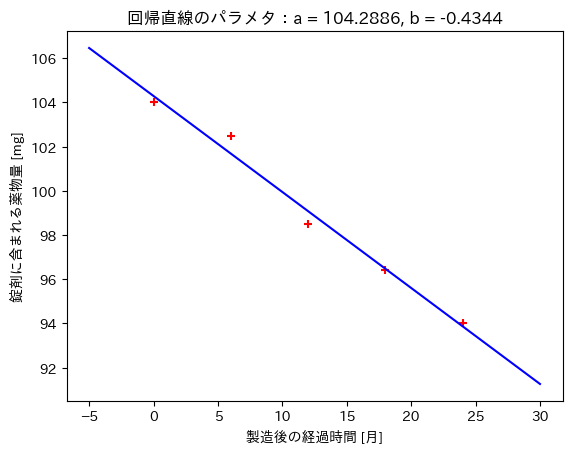

In [9]:
plt.plot(xx, yy, color='blue')
plt.scatter(X, t, marker='+', color='red')

plt.title('回帰直線のパラメタ：a = {a:.4f}, b = {b:.4f}'.format(a=a.item(), b=b.item()))
plt.xlabel('製造後の経過時間 [月]')
plt.ylabel('錠剤に含まれる薬物量 [mg]')

---

## (付録) 講義スライド掲載用の最小二乗法および自動微分のサンプルコード

In [10]:
import torch

X = torch.tensor([0, 6, 12, 18, 24])
t = torch.tensor([104, 102.5, 98.5, 96.4, 94])

MAX_ITER = 50000
lr = 1e-4

# パラメタの初期値を設定
# (requires_grad=Trueは勾配を計算したい変数であることを意味する)
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

for k in range(MAX_ITER):
    y = a + b * X
    loss = torch.sum((y - t) ** 2)

    # 計算グラフを loss ノードから
    # a, b, ノードに向かって逆に辿ることで微分値を計算
    a.grad = torch.tensor(0.0)
    b.grad = torch.tensor(0.0)
    loss.backward()

    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad

print(a, b)

tensor(104.2886, requires_grad=True) tensor(-0.4344, requires_grad=True)


In [11]:
import torch

X = torch.tensor(6)
t = torch.tensor(102.5)
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

L = 0.5 * (t - (a + b * X)) ** 2

L.backward()
print(a.grad, b.grad)

tensor(-95.5000) tensor(-573.)
